###  Introduction and Setup
We’ll create a minimal automatic differentiation system, similar to [micrograd](https://github.com/karpathy/micrograd), to demonstrate how backpropagation works under the hood. The idea is to build a Value class that records a computation graph node’s value and gradient, and supports basic arithmetic operations. Then we will implement a method to perform a backward pass (using the chain rule) to compute gradients through the graph, and use those gradients to perform gradient descent updates.

$$ loss = ((w1 - 1)^2 + (w2 - 5)^2) * 0.5 $$

In [24]:
# Let's start by defining a Value class to represent nodes in our computational graph.
class Value:
    def __init__(self, data, _children=(), _op=''):
        """
        Initialize a Value object.
        data: the numeric value (scalar) this node holds.
        _children: the nodes that produced this value (for building the graph).
        _op: the operation that produced this value (for debug/tracing purposes).
        """
        self.data = data                  # the actual scalar value
        self.grad = 0.0                   # gradient of the loss w.rt this value (to be computed in backprop)
        self._prev = set(_children)       # set of parent nodes (inputs to the operation that produced this node)
        self._op = _op                    # op name (optional, useful for debug)
        self._backward = lambda: None     # function to backpropagate gradient from this node to its _prev
    
    def __repr__(self):
        # For convenience, when we print a Value it will show its data
        return f"Value(data={self.data})"

In [25]:
w1 = Value(2.5)

In [27]:
w2 = Value(3.0)

In [29]:
w1 - 1 

TypeError: unsupported operand type(s) for -: 'Value' and 'int'

In [2]:
# Let's start by defining a Value class to represent nodes in our computational graph.
class Value:
    def __init__(self, data, _children=(), _op=''):
        """
        Initialize a Value object.
        data: the numeric value (scalar) this node holds.
        _children: the nodes that produced this value (for building the graph).
        _op: the operation that produced this value (for debug/tracing purposes).
        """
        self.data = data                  # the actual scalar value
        self.grad = 0.0                   # gradient of the loss w.rt this value (to be computed in backprop)
        self._prev = set(_children)       # set of parent nodes (inputs to the operation that produced this node)
        self._op = _op                    # op name (optional, useful for debug)
        self._backward = lambda: None     # function to backpropagate gradient from this node to its _prev
    
    def __repr__(self):
        # For convenience, when we print a Value it will show its data
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # Support addition: Value + Value or Value + scalar
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), _op='+')
        # Define the backward function for addition
        def _backward():
            # Gradient of the output w.rt each input is 1 (∂(a+b)/∂a = 1, ∂(a+b)/∂b = 1)
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        # Ensure commutativity: allows scalar + Value to use __add__
        return self + other

    def __mul__(self, other):
        # Support multiplication: Value * Value or Value * scalar
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), _op='*')
        def _backward():
            # ∂(a*b)/∂a = b, ∂(a*b)/∂b = a
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        # Ensure commutativity for scalar * Value
        return self * other

    def __sub__(self, other):
        # Define subtraction in terms of addition: a - b = a + (-b)
        return self + (-1 * other)

    def __pow__(self, exponent):
        # Only support exponent as int or float (scalar exponent)
        assert isinstance(exponent, (int, float)), "Only supporting int/float exponents for simplicity."
        out = Value(self.data ** exponent, (self,), _op=f'**{exponent}')
        def _backward():
            # ∂(a^k)/∂a = k * a^(k-1)
            self.grad += exponent * (self.data ** (exponent - 1)) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # Compute gradients of all values in the graph w.rt this Value (self).
        # 1. Topologically sort the graph of dependencies
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        # 2. Initialize the output node's gradient
        self.grad = 1.0
        # 3. Traverse nodes in reverse topological order and propagate gradients
        for node in reversed(topo):
            node._backward()


In [15]:
# Quick forward computation test:
w1 = Value(2.0)
w2 = Value(3.0)

# Construct an expression: ((w1 - 1)**2 + (w2 - 5)**2) * 0.5
a = w1 - 1
b = a**2
c = w2 - 5
d = c**2
s = b + d
loss = s * 0.5
print(loss)  # This is the loss given the current w1, w2

Value(data=2.5)


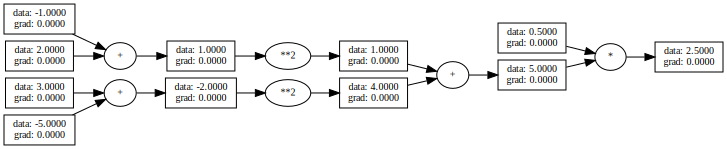

In [ ]:
draw_dot(loss)

### Forward Pass

1. **Inputs:**
   - $ w_1 = 2.0 $
   - $ w_2 = 3.0 $

2. **Intermediate Computations:**
   - **For $ w_1 $:**
     - $ a = w_1 - 1 = 2.0 - 1 = 1.0 $
     - $ b = a^2 = 1.0^2 = 1.0 $
   - **For $ w_2 $:**
     - $ c = w_2 - 5 = 3.0 - 5 = -2.0 $
     - $ d = c^2 = (-2.0)^2 = 4.0 $
   - **Combine and Scale:**
     - $ s = b + d = 1.0 + 4.0 = 5.0 $
     - $ \text{loss} = 0.5 \times s = 0.5 \times 5.0 = 2.5 $

---

### Backward Pass

Start by setting $\frac{d\,\text{loss}}{d\,\text{loss}} = 1$.

1. **Loss to Sum $ s $:**
   - $\frac{d\,\text{loss}}{d\,s} = 0.5$ since $\text{loss} = 0.5 \times s$.

2. **Gradients Through the Sum:**
   - Since $ s = b + d $:
     - $\frac{d\,s}{d\,b} = 1$
     - $\frac{d\,s}{d\,d} = 1$
   - Thus:
     - $\frac{d\,\text{loss}}{d\,b} = 0.5$
     - $\frac{d\,\text{loss}}{d\,d} = 0.5$

3. **Backpropagation to $ w_1 $:**
   - For $ b = a^2 $ where $ a = w_1 - 1 $:
     - $\frac{d\,b}{d\,a} = 2a$
     - At $ a = 1.0 $, this is $ 2 \times 1.0 = 2 $
     - So, $\frac{d\,\text{loss}}{d\,a} = \frac{d\,\text{loss}}{d\,b} \times \frac{d\,b}{d\,a} = 0.5 \times 2 = 1.0$
   - For $ a = w_1 - 1 $:
     - $\frac{d\,a}{d\,w_1} = 1$
     - Hence, $\frac{d\,\text{loss}}{d\,w_1} = 1.0 \times 1 = 1.0$

4. **Backpropagation to $ w_2 $:**
   - For $ d = c^2 $ where $ c = w_2 - 5 $:
     - $\frac{d\,d}{d\,c} = 2c$
     - At $ c = -2.0 $, this is $ 2 \times (-2.0) = -4 $
     - So, $\frac{d\,\text{loss}}{d\,c} = \frac{d\,\text{loss}}{d\,d} \times \frac{d\,d}{d\,c} = 0.5 \times (-4) = -2.0$
   - For $ c = w_2 - 5 $:
     - $\frac{d\,c}{d\,w_2} = 1$
     - Thus, $\frac{d\,\text{loss}}{d\,w_2} = -2.0 \times 1 = -2.0$

---

### Final Summary

- **Forward Computation:**
  - $ w_1 = 2.0 $, $ w_2 = 3.0 $
  - $ a = 1.0 $, $ b = 1.0 $
  - $ c = -2.0 $, $ d = 4.0 $
  - $ s = 5.0 $
  - $ \text{loss} = 2.5 $

- **Backward Computation:**
  - $\frac{d\,\text{loss}}{d\,w_1} = 1.0$
  - $\frac{d\,\text{loss}}{d\,w_2} = -2.0$

Thus, the gradient with respect to $ w_1 $ is **1.0**, and the gradient with respect to $ w_2 $ is **-2.0**.




In [8]:
# Perform backpropagation on the computational graph
loss.backward()
# After running backward, w1.grad and w2.grad should be populated with ∂loss/∂w1 and ∂loss/∂w2


print(f"∂loss/∂w1 = {w1.grad}")  # expected 1.0 (since w1-1 = 1)
print(f"∂loss/∂w2 = {w2.grad}")  # expected -2.0 (since w2-5 = -2)

∂loss/∂w1 = 1.0
∂loss/∂w2 = -2.0


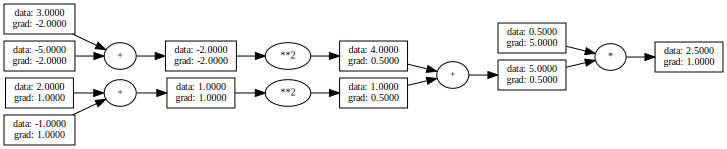

In [9]:
draw_dot(loss)

In [23]:
# Initialize parameters
w1 = Value(2.0)
w2 = Value(3.0)
params = [w1, w2]

learning_rate = 0.1  # choose a learning rate
for i in range(10):
    # 1. Forward pass: compute the loss for current w1, w2
    loss = 0.5 * ((w1 - 1)**2 + (w2 - 5)**2)
    print(f"Iteration {i}: loss = {loss.data:.4f}")
    # 2. Backward pass: compute gradients
    loss.backward()
    # 3. Gradient descent update: w <- w - α * grad
    for p in params:
        p.data -= learning_rate * p.grad
        #  Reset gradient to 0 for next iteration (since .backward() accumulates gradients)
        p.grad = 0.0

Iteration 0: loss = 2.5000
Iteration 1: loss = 2.0250
Iteration 2: loss = 1.6402
Iteration 3: loss = 1.3286
Iteration 4: loss = 1.0762
Iteration 5: loss = 0.8717
Iteration 6: loss = 0.7061
Iteration 7: loss = 0.5719
Iteration 8: loss = 0.4633
Iteration 9: loss = 0.3752


In [22]:
params

[Value(data=1.3486784401), Value(data=4.3026431198)]

## 1. Value Class

The `Value` class holds a `data` attribute for the actual number and a `grad` attribute for the gradient (initially 0). 
The `_prev` set will store references to parent nodes in the graph (so we know from which values this was computed). 
We also reserve a `_backward` function, which, for each Value, will be defined to propagate gradients to its parents. 
Initially, we set `_backward` to a no-op (`lambda: None`); it will be overwritten when we define specific operations.

Next, we want `Value` objects to behave like numbers in expressions. 
We’ll implement **operator overloading** for addition, multiplication, etc., so that when we write expressions involving `Value` objects, new `Value` nodes are created and linked in the graph. Crucially, when we create a new `Value` as a result of an operation, we also set its `_backward` function to capture the **local derivatives** for that operation, so we know how to propagate gradients backward later.

## 2. Basic Operations

We implemented `__add__`, `__mul__`, and their right-hand versions to handle expressions like `Value + 5` or `2 * Value`. 
We also implemented `__sub__` (using the trick that subtraction is just adding a negation) and `__pow__` for exponentiation. 

**Explanation of `_backward` definitions:**
- For addition (`+`): The local derivatives $\frac{\partial (a+b)}{\partial a} = 1$ and $\frac{\partial (a+b)}{\partial b} = 1$. So when backpropagating, we simply pass the output gradient to both `self` and `other`. In code, `out.grad` represents $\frac{\partial L}{\partial (a+b)}$ (the gradient of loss w.rt the sum); we add that to `self.grad` and `other.grad`. We use `+=` because if a Value is used in multiple places, gradients from each usage will accumulate (this is important in DAGs where one node branches out to multiple outputs).
- For multiplication (`*`): If $out = a * b$, then $\frac{\partial out}{\partial a} = b$ and $\frac{\partial out}{\partial b} = a$. So we propagate `out.grad` (which is $\frac{\partial L}{\partial (a*b)}$) to `self.grad` scaled by `other.data` (the value of $b$), and to `other.grad` scaled by `self.data` (the value of $a$). This implements the chain rule: $\frac{\partial L}{\partial a} = \frac{\partial L}{\partial out} \cdot \frac{\partial out}{\partial a} = out.grad * b$.
- For power (`**`): If $out = a^k$, $\frac{\partial out}{\partial a} = k \cdot a^{k-1}$. So we add `out.grad * (k * a^(k-1))` to `self.grad`. For example, if we square a value (`exponent=2`), this says $\frac{\partial (a^2)}{\partial a} = 2a$, so we’d do `self.grad += 2 * self.data * out.grad`.

Now that basic operations are defined, we can do forward computations with `Value` objects that will automatically build a computation graph. Let’s test this with a simple example and then implement the **backward pass** to compute gradients through that graph.

In [9]:
# Quick forward computation test:
w1 = Value(2.0)
w2 = Value(3.0)
# Construct an expression: ((w1 - 1)**2 + (w2 - 5)**2) * 0.5
loss = ((w1 - 1)**2 + (w2 - 5)**2) * 0.5
print(loss)  # This is the loss given the current w1, w2

Value(data=2.5)


If our code is correct so far, this should output a `Value` with the loss. We expect `w1=2, w2=3` to yield:  
- $(w1 - 1)^2 = (2-1)^2 = 1$  
- $(w2 - 5)^2 = (3-5)^2 = 4$  
- Sum = $1 + 4 = 5$  
- Half of that = $2.5$  

So `loss` should be `Value(data=2.5)`. 
The printout will invoke `__repr__`, showing something like `Value(data=2.5)`. 
This confirms the forward pass and graph construction are working.

## 3. Backward Pass

Now, the critical part: implementing backpropagation. 
We need to traverse the graph we built in the forward pass **in reverse topological order**, calling each node’s `_backward` to propagate the gradient. 
We will implement a method `backward()` for the `Value` class that does this. It will: 
1. Start with the current node (typically the final `loss` node) and set its gradient to 1 (since $\frac{\partial L}{\partial L} = 1$).  
2. Perform a graph traversal (depth-first search) to build a list of all nodes in the graph, in topologically sorted order.  
3. Iterate over this list in reverse (from outputs back to inputs), and call each node’s `_backward()` method, which updates its parents’ gradients.

Let’s break down how this works:
- `build_topo(self)`: This is a recursive function that visits all ancestors of `self` (the current node). It ensures that we visit inputs before outputs. By appending a node *after* visiting its children, we accumulate `topo` as a list sorted such that if `A` depends on `B`, then `B` comes before `A` in `topo`. This is a typical depth-first search for topological ordering in a DAG.  
- After building the `topo` list, we set `self.grad = 1.0` to start the backpropagation at the loss node. This signifies $\frac{\partial L}{\partial L} = 1$.  
- Then we iterate `for node in reversed(topo): node._backward()`. The `topo` list currently goes from input nodes up to `self`; reversing it means we go from `self` (output/loss) back down to inputs. Calling `node._backward()` applies the chain rule: it takes the gradient accumulated in `node.grad` and distributes it to `node`’s parents (adding to their `grad`). This will ultimately fill in `grad` for every `Value` that influenced `self`.

Now we can test the full backpropagation on our example. We expect to get the gradients of `loss` w.rt `w1` and `w2`. For the function $L = 0.5[(w_1 - 1)^2 + (w_2 - 5)^2]$, the partial derivatives are: 
$\frac{\partial L}{\partial w_1} = (w_1 - 1)$ and $\frac{\partial L}{\partial w_2} = (w_2 - 5)$ (because $\partial \frac{1}{2}(x-c)^2/\partial x = x-c$). At $w_1=2, w_2=3$, we expect $\nabla_{w1}L = 1.0$ and $\nabla_{w2}L = -2.0$.

In [10]:
# Perform backpropagation on the computational graph
loss.backward()
# After running backward, w1.grad and w2.grad should be populated with ∂loss/∂w1 and ∂loss/∂w2
print(f"∂loss/∂w1 = {w1.grad}")  # expected 1.0 (since w1-1 = 1)
print(f"∂loss/∂w2 = {w2.grad}")  # expected -2.0 (since w2-5 = -2)

∂loss/∂w1 = 1.0
∂loss/∂w2 = -2.0


### Using Gradient Descent to Optimize

Now that we can compute gradients, let’s use them to perform gradient descent and **optimize** the toy function above. We’ll treat $w1$ and $w2$ as parameters we can adjust, and try to find the values that minimize our loss $L = 0.5[(w1 - 1)^2 + (w2 - 5)^2]$. Intuitively, the minimum occurs at $w1 = 1, w2 = 5$ (that makes each squared term zero, yielding loss 0). Gradient descent should drive $w1, w2$ toward those values.

We’ll do a simple loop of updates:
1. Forward pass: compute loss for current $w1, w2$.  
2. Backward pass: compute gradients.  
3. Gradient step: update $w1.data$ and $w2.data$ using a chosen learning rate.  
4. Repeat for a number of iterations (epochs).

In [ ]:
# Initialize parameters
w1 = Value(2.0)
w2 = Value(3.0)
params = [w1, w2]

learning_rate = 0.1  # choose a learning rate
for i in range(10):
    # 1. Forward pass: compute the loss for current w1, w2
    loss = 0.5 * ((w1 - 1)**2 + (w2 - 5)**2)
    print(f"Iteration {i}: loss = {loss.data:.4f}")
    # 2. Backward pass: compute gradients
    loss.backward()
    # 3. Gradient descent update: w <- w - α * grad
    for p in params:
        p.data -= learning_rate * p.grad
        #  Reset gradient to 0 for next iteration (since .backward() accumulates gradients)
        p.grad = 0.0

Iteration 0: loss = 2.5000
Iteration 1: loss = 0.6250
Iteration 2: loss = 0.1562
Iteration 3: loss = 0.0391
Iteration 4: loss = 0.0098
Iteration 5: loss = 0.0024
Iteration 6: loss = 0.0006
Iteration 7: loss = 0.0002
Iteration 8: loss = 0.0000
Iteration 9: loss = 0.0000


In each iteration, we print the current loss. We also reset gradients to 0 after each update because our `backward()` method **accumulates** gradients in each variable (we don’t want to carry over gradients from previous iterations).

Let’s interpret the output. Starting from $w1=2, w2=3$:
- Iteration 0: We already calculated loss = 2.5. After backprop, $w1.grad = 1.0, w2.grad = -2.0$. With a learning rate of 0.1, the update step does:  
  $w1_{\text{new}} = 2.0 - 0.1 * (1.0) = 1.9$  
  $w2_{\text{new}} = 3.0 - 0.1 * (-2.0) = 3.0 + 0.2 = 3.2$.
- Iteration 1: Now $w1=1.9, w2=3.2$. The loss should have decreased. The loop will compute the new loss and gradients, and update again.

If you run the above code, you’d see the loss decreasing each time. By the end of 10 iterations, $w1` and $w2$ move closer to 1 and 5, and the loss is much smaller. This is the essence of training a neural network: iteratively adjusting weights to minimize a loss function.

After training, the parameters converge to the optimal values (approximately $w1 = 1.0$, $w2 = 5.0$) that minimize the loss. 
This simple exercise shows how backpropagation and gradient descent work together: **backprop** computes the direction to adjust each parameter to reduce error, and **gradient descent** updates the parameters in that direction.

### Extending to Neural Networks (Discussion)

Our example was a simple function of two variables. In a neural network with many weights, the process is conceptually the same – just applied at a larger scale:
- The forward pass computes outputs (and ultimately a loss) from inputs by flowing through layers.
- Backpropagation computes the gradient of the loss w.rt. each weight (using the chain rule through the network graph).
- An optimizer (usually stochastic gradient descent or a variant) adjusts each weight slightly in the negative gradient direction.

Modern autograd frameworks (TensorFlow, PyTorch, etc.) automate this process. 
What we built is essentially a **tiny autograd engine**. 
In fact, Karpathy’s full `micrograd` project is only about ~100 lines for the core engine and demonstrates that even complex networks can be trained by systematically applying these principles ([GitHub - karpathy/micrograd: A tiny scalar-valued autograd engine and a neural net library on top of it with PyTorch-like API](https://github.com/karpathy/micrograd#:~:text=A%20tiny%20Autograd%20engine%20,Potentially%20useful%20for%20educational%20purposes)).

By coding it ourselves, we demystified the backpropagation algorithm: it’s just bookkeeping of local derivatives and recursive application of the chain rule! This understanding will help you debug neural network training and grasp what frameworks are doing under the hood when you call `.backward()` or `.step()`.

In [6]:
# visualization related

def vis_color(nodes, color):
    # colors a set of nodes (for visualization)
    for n in nodes:
        setattr(n, '_vis_color', color)

def trace(root):
    # traces the full graph of nodes and edges starting from the root
    nodes, edges = [], []
    def build(v):
        if v not in nodes:
            nodes.append(v)
            for child in v._prev:
                if (child, v) not in edges:
                    edges.append((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR', outfile='graph'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    # brew install graphviz
    # pip install graphviz
    from graphviz import Digraph
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir, 'nodesep': '0.1', 'ranksep': '0.4'})

    for n in nodes:
        fillcolor = n._vis_color if hasattr(n, '_vis_color') else "white"
        dot.node(name=str(id(n)), label="data: %.4f\ngrad: %.4f" % (n.data, n.grad), shape='box', style='filled', fillcolor=fillcolor, width='0.1', height='0.1', fontsize='10')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op, width='0.1', height='0.1', fontsize='10')
            dot.edge(str(id(n)) + n._op, str(id(n)), minlen='1')

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op, minlen='1')

    #print("found a total of ", len(nodes), "nodes and", len(edges), "edges")
    #print("saving graph to", outfile + "." + format)
    #dot.render(outfile, format=format)
    return dot